In [1]:
import cv2
import torch
import random

import numpy as np
import torch.nn as nn

from torchsummary import summary
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 "LGES_240621"로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES_240621

In [2]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 2024
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

#### VGG16에 CAM 적용하기

CAM은 Global Average Pooling layer에 FC layer를 붙여 classifier를 구성

VGG16의 classifier 변경 필요

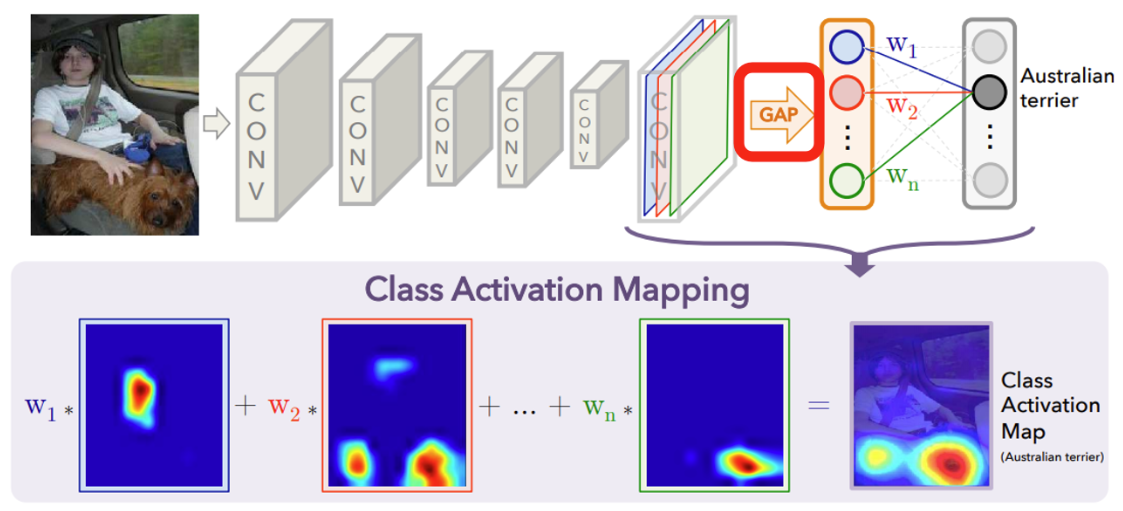

In [1]:
from PIL import Image
Image.open('./images/img6-1.png')

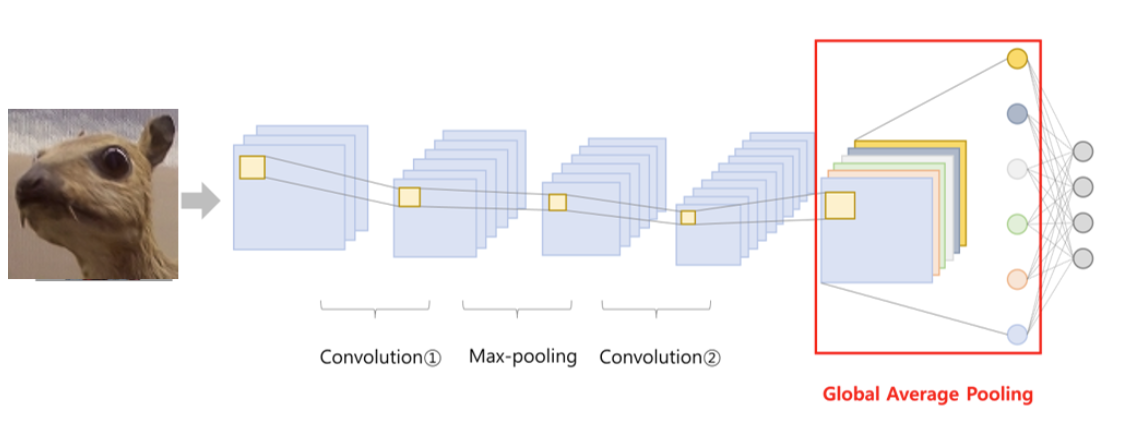

In [2]:
Image.open('./images/img6-2.png')

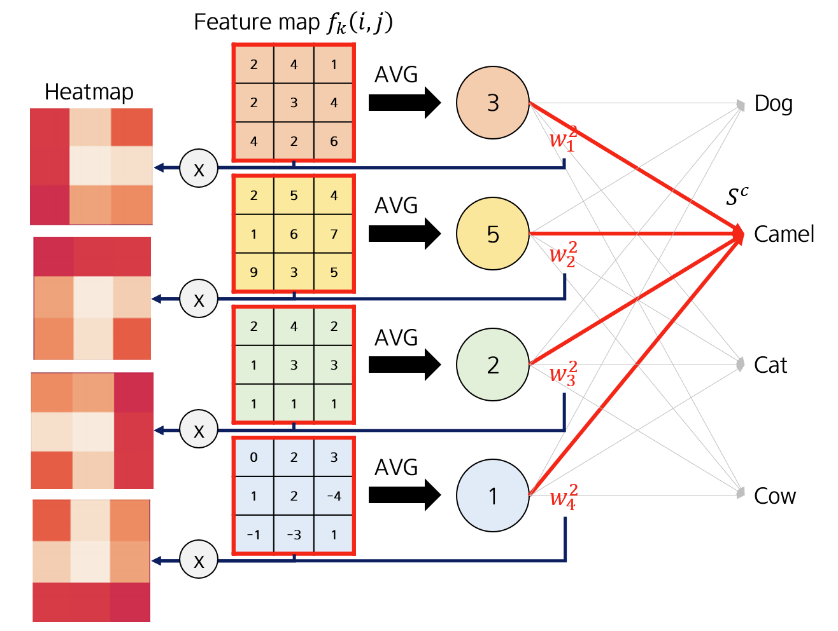

In [3]:
Image.open('./images/img6-3.png')

In [3]:
from torchvision.models import vgg16, VGG16_Weights

model_vgg = vgg16(weights=VGG16_Weights.DEFAULT)

summary(model_vgg, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [4]:
summary(model_vgg.features, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [5]:
summary(model_vgg.features[:30], input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [6]:
del model_vgg

In [7]:

# vgg16에서 feature extractor만 선택하고 classifier 재정의 하는 모델 정의
# Global Average Pooling 
class vgg16_cam(nn.Module):
    def __init__(self):
        super(vgg16_cam, self).__init__()
        
        # VGG 모델을 정의하고 catdog으로 학습시킨 파라미터 불러오기
        base_vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        in_features =base_vgg.classifier[-1].in_features
        base_vgg.classifier[-1] = nn.Linear(in_features, 2)
        parameters = torch.load('./results/cat_dog_vgg16.pt')['model']
        base_vgg.load_state_dict(parameters)
        
        # classifier 부분을 avgpool로 교체
        self.feature_extractor = base_vgg.features[:30]
        self.gap = nn.AvgPool2d(kernel_size=(8,8))
        self.fc = nn.Linear(512, 2)
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
    def forward(self, x):
        # B, 3, 128, 128
        feats = self.feature_extractor(x) # B, 512, 8, 8
        out = self.gap(feats) # B, 512, 1, 1
        out = self.flatten(out) # B, 512
        out = self.fc(out) # B, num classes
        
        return out 

    # 해당 이미지에 대한 feature를 반환하는 함수
    def get_activations(self, x):
        return self.feature_extractor(x)

vgg_cam = vgg16_cam()
vgg_cam.eval()

summary(vgg_cam, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

#### CAM 코드
https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py

In [8]:
def return_CAM(feature_conv, weight, class_idx):
    # feats : N, 512, 8, 8
    # weight : C, 512
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot) # 해당 class에 대한 weight에 featuremap 곱하기
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam) # minmax-saleing
        cam_img = cam / np.max(cam) # minmax-saleing
        cam_img = np.uint8(255 * cam_img)  # 0~255로 scale 변환
        output_cam.append(cv2.resize(cam_img, size_upsample))
        
    return output_cam

#### test data에 대해 CAM 적용

torch.Size([1, 3, 128, 128])


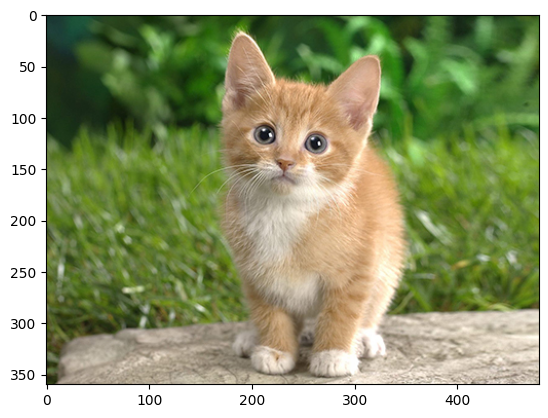

In [9]:
import torchvision.transforms as tf

test_img = Image.open('./data/cute.jpg')
plt.imshow(test_img)

preprocess = tf.Compose([
   tf.Resize((128,128)),
   tf.ToTensor()
])

test_img = preprocess(test_img)
test_img = test_img.unsqueeze(0) # 1, 3, 128, 128
print(test_img.shape)

In [10]:
out = vgg_cam(test_img)
feat = vgg_cam.get_activations(test_img)
print(out.shape, feat.shape)

torch.Size([1, 2]) torch.Size([1, 512, 8, 8])


In [11]:
# Softmax 함수를 적용하여 확률값 구하기
h_x = F.softmax(out, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()

In [12]:
# las conv layer feature
feat_numpy = feat.cpu().detach().numpy()

In [13]:
params = list(vgg_cam.fc.parameters()) # params[0] : weight, params[1] : bias
weight = np.squeeze(params[0].data.numpy())
weight.shape

(2, 512)

In [14]:
# Class Activation Map
CAMs = return_CAM(feat_numpy, weight, [idx[0]])

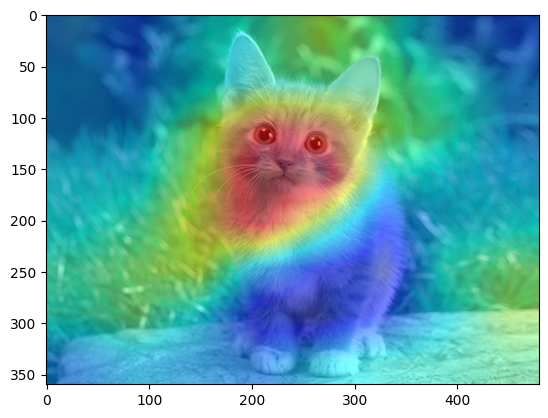

In [15]:
# CAM 결과 히트맵 시각화 & 저장
img = cv2.imread('./data/cute.jpg') # numpy로 load : H,W,3
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.5 + img * 0.5

cv2.imwrite('./results/CAM_result.png', result)
plt.imshow(result/255.)

#### VGG16에 Grad-CAM 적용하기

https://github.com/zhuokaizhao/Grad-CAM-VGG19-PyTorch/blob/main/model.py

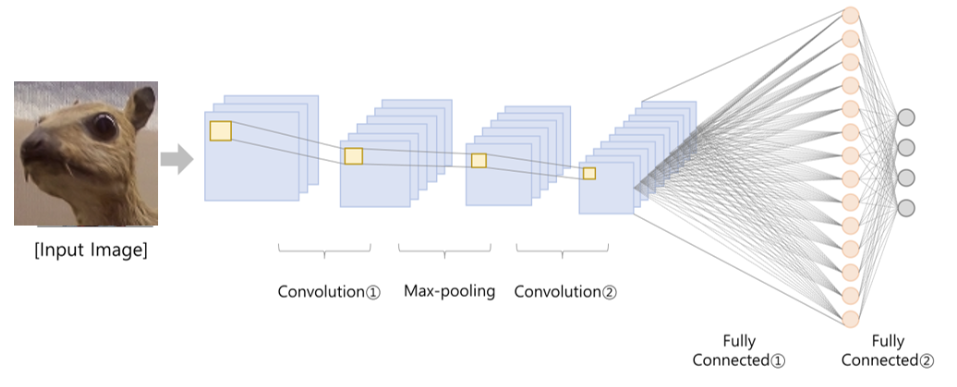

In [4]:
Image.open('./images/img6-4.png')

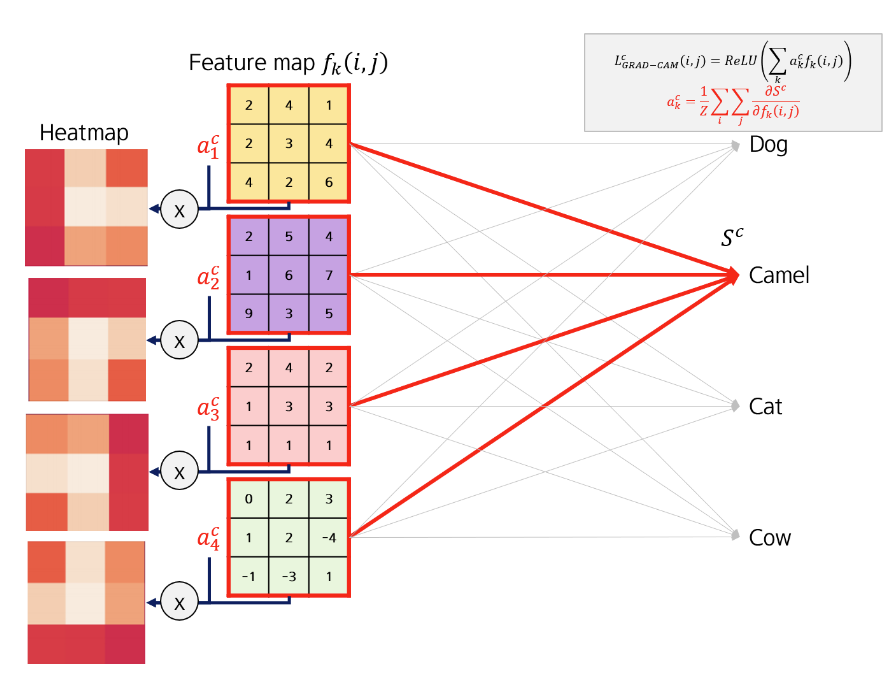

In [5]:
Image.open('./images/img6-5.png')

In [16]:
class vgg_gradcam(nn.Module):
    def __init__(self):
        super(vgg_gradcam, self).__init__()

        # VGG 모델을 정의하고 catdog으로 학습시킨 파라미터 불러오기
        base_vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        in_features =base_vgg.classifier[-1].in_features
        base_vgg.classifier[-1] = nn.Linear(in_features, 2)
        parameters = torch.load('./results/cat_dog_vgg16.pt', map_location='cpu')['model']
        base_vgg.load_state_dict(parameters)
        
        # feature extractor 부분과 classifier 나누기
        self.feature_extractor = base_vgg.features
        self.avgpool = base_vgg.avgpool
        self.classifier = base_vgg.classifier
        self.flatten = nn.Flatten()

        # gradient를 저장하는 변수
        self.gradients = None

    # gradient가 계산되면 gradients 변수에 저장하는 함수
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.feature_extractor(x)

        # register the hook -> gradient가 계산될 때마다 activations_hook 함수 호출
        h = x.register_hook(self.activations_hook)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    # gradient를 출력하는 함수
    def get_activations_gradient(self):
        return self.gradients

    # 해당 이미지에 대한 feature를 반환하는 함수
    def get_activations(self, x):
        return self.feature_extractor(x)

In [17]:
# initialize the VGG model
vgg_grad = vgg_gradcam()

# set the evaluation mode
vgg_grad.eval()

summary(vgg_grad, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

torch.Size([1, 3, 128, 128])


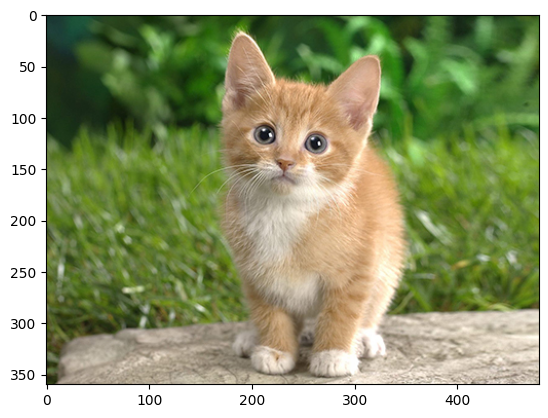

In [19]:
test_img = Image.open('./data/cute.jpg')
plt.imshow(test_img)

preprocess = tf.Compose([
   tf.Resize((128,128)),
   tf.ToTensor()
])

test_img = preprocess(test_img)
test_img = test_img.unsqueeze(0) # 1, 3, 128, 128
print(test_img.shape)

In [35]:
logits = vgg_grad(test_img) # class logits
pred = logits.argmax(dim=1) # 예측 레이블
pred_logit = logits[:,pred] # 예측 레이블에 대한 logit값

In [36]:
def return_GradCAM(pred_logit, model, image):
    # 예측한 클래스의 logit값에 대해 backward 진행
    pred_logit.backward()

    # 계산된 gradient 가져오기
    gradients = model.get_activations_gradient() # B, 512, 4, 4

    # featuremap을 기준으로 gradient 값 평균 계산 = 각 featuremap 별 weight
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # 512

    # feature 추출
    activations = model.get_activations(image).detach()

    # 각 featuremap마다 weight 곱해주기
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # featuremap weightsum
    heatmap = torch.mean(activations, dim=1).squeeze()

    # 음수 제거
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap.to('cpu'), 0)

    # minmax scaling
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.squeeze())
    plt.show()
    
    return heatmap

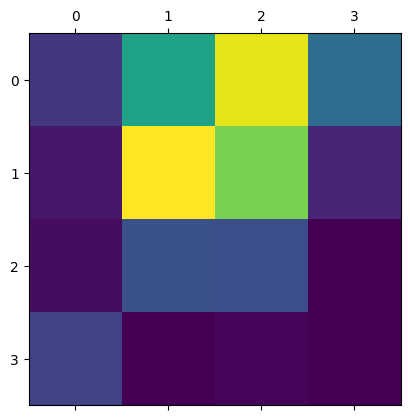

In [37]:
GradCAMs = return_GradCAM(pred_logit, vgg_grad, test_img)

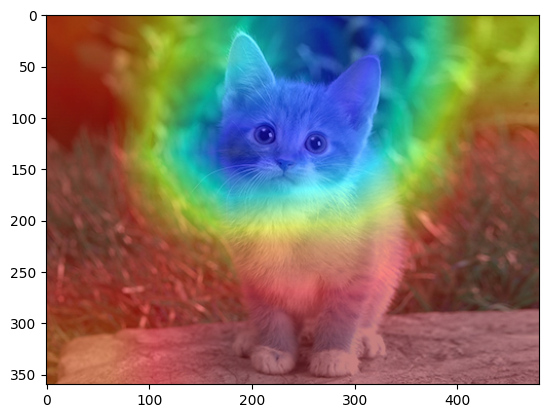

In [38]:
# GradCAM 결과 히트맵 시각화 & 저장
img2 = cv2.imread('./data/cute.jpg')
height, width, _ = img2.shape

heatmap = cv2.resize(GradCAMs.numpy(), (width, height))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
result = heatmap * 0.5 + img2 * 0.5
cv2.imwrite('./results/GradCAM_result.png', result)
plt.imshow(result/255.)